In [1]:
## Add imports here
import torch
import torch.nn as nn
from collections import Counter
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import math 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


torch.manual_seed(75323498282500)  # For reproducibility

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_LEN = 256 # Maximum sequence length

def initialise_projections(d_model, n_heads):
    """
    Create projections for Q, K, V.
    """
    d_k = d_model // n_heads
    return (nn.Linear(d_model, d_k),
            nn.Linear(d_model, d_k),
            nn.Linear(d_model, d_k))

def pairwise_similarities(Q, K):
    """
    Compute dot product attention.
    """
    return torch.matmul(Q, K.transpose(-2, -1))

def attention_scaled(similarities, d_k):
    """
    Scale the raw attention scores.
    """
    return similarities / np.sqrt(d_k)

def attention_softmax(scaled_similarities):
    """
    Normalize the scaled raw attention scores with softmax.
    """
    return F.softmax(scaled_similarities, dim=-1)

def compute_outputs(attention, V):
    """
    Get outputs as a weighted sum of values by attention scores.
    """
    return torch.matmul(attention, V)

def make_causal_mask(size):
    """
    Create a mask matrix that masks future context for the attention.
    """
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return mask == 0

def apply_causal_mask(attention_scores, mask):
    """
    Apply mask to attention.
    """
    return attention_scores.masked_fill(~mask, float('-inf'))

def split_heads(x, n_heads):
    """
    Splitting the input across multiple heads.
    """
    batch_size, seq_len, d_model = x.size()
    return x.view(batch_size, seq_len, n_heads, -1).transpose(1, 2)

def merge_heads(x):
    """
    Reversing splitting action of function split_heads().
    """
    batch_size, n_heads, seq_len, d_k = x.size()
    return x.transpose(1, 2).contiguous().view(batch_size, seq_len, n_heads * d_k)

def self_attention(Q, K, V, mask=None):
    """
    Self-attention block.
    """
    similarities = pairwise_similarities(Q, K)
    if mask is not None:
        similarities = apply_causal_mask(similarities, mask)
    attention = attention_softmax(similarities)
    return compute_outputs(attention, V), attention

def split_heads_qkv(Q, K, V, n_heads):
    """
    Split Q, K, V across multiple heads.
    """
    return (split_heads(Q, n_heads),
            split_heads(K, n_heads),
            split_heads(V, n_heads))

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = torch.tensor(tokenize(text, pad_to_len=self.max_len, tokenizer=self.tokenizer), 
                            dtype=torch.long)
        return tokens

def load_and_preprocess_data():
    # Special tokens
    special_tokens = {
        "<PAD>": 0,
        "<START>": 1,
        "<STOP>": 2,
        "<UNK>": 3
    }
    
    # Read data files
    with open("shakespear_train.txt", "r") as f:
        lines_train = f.readlines()
    with open("shakespear_dev.txt", "r") as f:
        lines_dev = f.readlines()

    # Create vocabulary from training data
    tokens_train = [line.split() for line in lines_train]
    token_counts = Counter(token for sent in tokens_train for token in sent)

    # Create tokenizer starting with special tokens
    tokenizer = special_tokens.copy()
    
    # Add regular tokens
    tokenizer.update({
        token: i + len(special_tokens)
        for i, (token, _) in enumerate(token_counts.most_common())
    })

    # Create inverse tokenizer
    tokenizer_inv = {v: k for k, v in tokenizer.items()}
    
    # Create datasets
    train_dataset = TextDataset(lines_train, tokenizer)
    val_dataset = TextDataset(lines_dev, tokenizer)

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

def pad_to_length(tokens, max_len, tokenizer):
    """
    Pad tokens to a fixed length.
    """
    return tokens[:max_len] + [tokenizer["<PAD>"]] * (max_len - len(tokens))

def tokenize(sentence, pad_to_len=None, tokenizer=None, include_stop=True):
    """
    Tokenize a sentence.
    """
    tokens = [tokenizer.get(t, tokenizer["<UNK>"]) for t in sentence.split()]
    if include_stop:
        tokens = [tokenizer["<START>"]] + tokens + [tokenizer["<STOP>"]]
    if pad_to_len:
        tokens = pad_to_length(tokens, pad_to_len, tokenizer)
    return tokens

def decode(tokens, tokenizer_inv, end_at_stop=True, omit_pad=True):
    """
    Decode tokens to text.
    """
    # Convert tokens to list if they're not already
    if not isinstance(tokens, list):
        tokens = tokens.tolist()
    
    # Find the end index if STOP token is present
    if end_at_stop and tokenizer_inv[2] == "<STOP>":  # 2 is the index for <STOP>
        try:
            end_idx = tokens.index(2)  # Using the numeric index directly
            tokens = tokens[:end_idx]
        except ValueError:
            pass
    
    # Remove padding tokens
    if omit_pad:
        tokens = [t for t in tokens if t != 0]  # 0 is the index for <PAD>
    
    # Convert to text, excluding special tokens
    special_tokens = {"<PAD>", "<START>", "<STOP>", "<UNK>"}
    text_tokens = [tokenizer_inv[t] for t in tokens]
    text_tokens = [t for t in text_tokens if t not in special_tokens]
    
    return " ".join(text_tokens)

@torch.no_grad()
def evaluate_losses(data, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress:
        it = tqdm(it)

    out = []
    for b_start in it:
        batch = slice(b_start, b_start + bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len, tokenizer=tokenizer) for t in data[batch]], dtype=torch.long
        ).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()

        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]

        for i in range(y_tokens.shape[0]):
            not_pad = y_tokens[i] != tokenizer["<PAD>"]
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())

    return out

def generate_text(model, tokenizer, tokenizer_inv, context="<START>", gen_tokens=10, temperature=0.6):
    """
    Generate a fixed number of tokens using the trained model.
    """
    # Handle empty or None context
    if not context or context.isspace():
        context = "<START>"
    
    # Tokenize the context
    context_tokens = tokenize(context, tokenizer=tokenizer, include_stop=False)
    tokens = torch.tensor([context_tokens], dtype=torch.long).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        for _ in range(gen_tokens):
            # Get predictions
            logits, _ = model(tokens)
            
            # Focus on the last token's predictions
            next_token_logits = logits[:, -1, :] / temperature
            
            # Apply softmax to get probabilities
            probabilities = F.softmax(next_token_logits, dim=-1)
            
            # Sample from the distribution
            next_token = torch.multinomial(probabilities, 1)
            
            # Append to the context
            tokens = torch.cat([tokens, next_token], dim=1)

            # Stop if we generated a STOP token
            if next_token.item() == tokenizer["<STOP>"]:
                break
    
    # Convert back to text
    generated_text = decode(tokens[0].tolist(), tokenizer_inv)
    return generated_text

In [2]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, dropout):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = self._create_pos_encoding(MAX_LEN, d_model)
        self.dropout = nn.Dropout(dropout)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, dropout) for _ in range(n_layers)
        ])
        self.output_layer = nn.Linear(d_model, vocab_size)
        self._init_weights()

    def _create_pos_encoding(self, max_len, d_model):
        pos_enc = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 1::2] = torch.cos(position * div_term)
        return pos_enc.to(DEVICE)

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        B, T = x.shape
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = x + self.pos_encoding[:T]
        x = self.dropout(x)
        
        attentions = []
        mask = make_causal_mask(T).to(DEVICE)
        
        for block in self.transformer_blocks:
            x, attention = block(x, mask)
            attentions.append(attention)
            
        logits = self.output_layer(x)
        return logits, attentions

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attended, attention = self.attention(x, mask)
        x = self.norm1(x + attended)
        x = self.norm2(x + self.feed_forward(x))
        return x, attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        Q = split_heads(self.Q(x), self.n_heads)
        K = split_heads(self.K(x), self.n_heads)
        V = split_heads(self.V(x), self.n_heads)
        
        x, attention = self_attention(Q, K, V, mask)
        x = merge_heads(x)
        x = self.out(x)
        return x, attention

def train_model(model, tokenizer, tokenizer_inv, train_loader, val_loader, num_epochs, lr):
    val_file = "shakespear_dev.txt"
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cross_entropy_loss = nn.CrossEntropyLoss(ignore_index=tokenizer["<PAD>"])
    train_losses = []
    val_losses = []
    val_perplexities = []
    model.to(DEVICE)
    
    # Sample text generation context
    context = "First Citizen :"
    
    for epoch in range(num_epochs):
        print("Epoch", epoch + 1)
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_seq = batch[:, :-1].to(DEVICE)
            target_seq = batch[:, 1:].to(DEVICE)
            
            logits, _ = model(input_seq)
            loss = cross_entropy_loss(logits.view(-1, logits.size(-1)), target_seq.view(-1))
            
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        
        with torch.no_grad():
            with open(val_file, "r") as f:
                val_lines = f.readlines()
            val_loss = np.mean(evaluate_losses(val_lines, model, tokenizer))
            val_losses.append(val_loss)
            ppl = np.exp(np.mean(val_loss))
            generated_text = generate_text(model, tokenizer, tokenizer_inv, gen_tokens=10)
            val_perplexities.append(ppl)

        print("Train Loss =" ,avg_train_loss , "\nVal Loss =", val_loss)
        print("Val Perplexity =",ppl)
        print(generated_text,"\n")
        
    return train_losses, val_losses, val_perplexities

In [3]:
#config
d_model =64 #embedding dimension
n_heads = 4 #number of heads
n_layers = 6 #number of layers
dropout = 0.1 #dropout rate
num_epochs = 11
lr = 1e-4

TransformerLM(
  (embedding): Embedding(12575, 64)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention): MultiHeadAttention(
        (Q): Linear(in_features=64, out_features=64, bias=True)
        (K): Linear(in_features=64, out_features=64, bias=True)
        (V): Linear(in_features=64, out_features=64, bias=True)
        (out): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (output_layer): Linear(in_features=64, out_features=12575, bias=True)
)
Epoch 1


100%|██████████| 41/41 [00:00<00:00, 45.65it/s]


Train Loss = 8.32176714593714 
Val Loss = 7.351795969199549
Val Perplexity = 1558.9939201328789
she budger starts How thee naked supper Anthony them , 

Epoch 2


100%|██████████| 41/41 [00:00<00:00, 42.28it/s]


Train Loss = 6.84551706871429 
Val Loss = 6.416178563621147
Val Perplexity = 611.6612178422945
. 

Epoch 3


100%|██████████| 41/41 [00:00<00:00, 43.64it/s]


Train Loss = 6.379807012421744 
Val Loss = 6.159781591292539
Val Perplexity = 473.3246853119314
 

Epoch 4


100%|██████████| 41/41 [00:00<00:00, 44.46it/s]


Train Loss = 6.171384853202027 
Val Loss = 5.8892652970150206
Val Perplexity = 361.13985634839065
: this and a in , me : , your 

Epoch 5


100%|██████████| 41/41 [00:00<00:00, 45.12it/s]


Train Loss = 5.9780627334272705 
Val Loss = 5.702256333242896
Val Perplexity = 299.54250676449084
my the see the bald : it , , ; 

Epoch 6


100%|██████████| 41/41 [00:00<00:00, 45.36it/s]


Train Loss = 5.818511595973721 
Val Loss = 5.569255117624084
Val Perplexity = 262.23868949258923
KING KING : : KING ; : : : : 

Epoch 7


100%|██████████| 41/41 [00:00<00:00, 46.29it/s]


Train Loss = 5.685118689165487 
Val Loss = 5.46709050960336
Val Perplexity = 236.77030870292842
: My Virtue me , And As this shall they 

Epoch 8


100%|██████████| 41/41 [00:00<00:00, 45.27it/s]


Train Loss = 5.588237748517619 
Val Loss = 5.419835660720896
Val Perplexity = 225.84200473991328
KING MENENIUS : SICINIUS : Come , men , I 

Epoch 9


100%|██████████| 41/41 [00:00<00:00, 45.73it/s]


Train Loss = 5.513295480183193 
Val Loss = 5.366455275222568
Val Perplexity = 214.10258626374633
What , I all be so my shalt the queen 

Epoch 10


100%|██████████| 41/41 [00:00<00:00, 45.01it/s]


Train Loss = 5.449426468316611 
Val Loss = 5.3457492182225534
Val Perplexity = 209.7149480147315
God , I ? 

Epoch 11


100%|██████████| 41/41 [00:00<00:00, 44.09it/s]


Train Loss = 5.400529036274204 
Val Loss = 5.300379737023196
Val Perplexity = 200.41289972478128
QUEEN : Now , We that you have an glory 



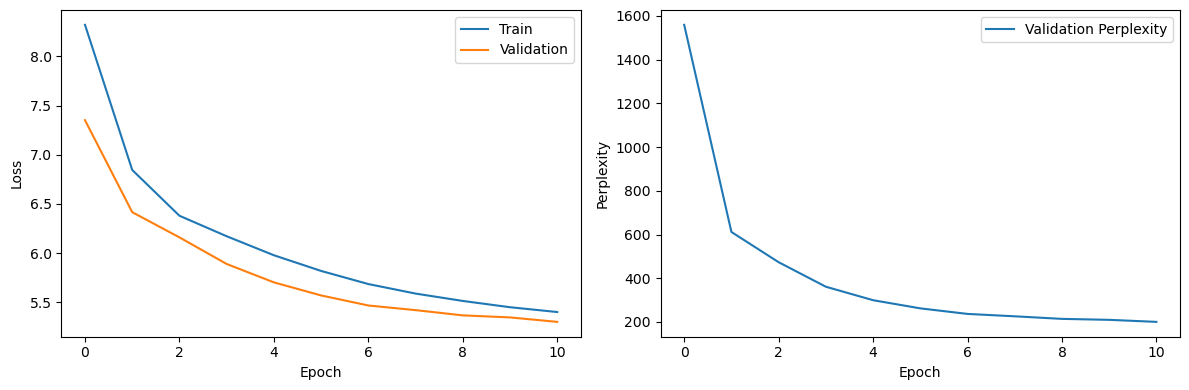

In [ ]:
train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

vocab_size = len(tokenizer)

model = TransformerLM(vocab_size, d_model, n_heads, n_layers, dropout).to(DEVICE)
print(model)

train_losses, val_losses, val_perplexities = train_model(model, tokenizer, tokenizer_inv, train_loader, val_loader, num_epochs, lr)
torch.save(model.state_dict(), 'transformer_lm.pt')

# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot perplexity
plt.subplot(1, 2, 2)
plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
def inference(model, test_file, tokenizer, tokenizer_inv):
    # Read and process the input from test file
    with open(test_file, "r") as f:
        test_lines = f.readlines()
    
    # Generate text for each line
    generated_texts = []
    for line in test_lines:
        text = generate_text(model, tokenizer, tokenizer_inv, context="<START>")
        generated_texts.append(text)

    losses = evaluate_losses(test_lines, model, tokenizer)
    ppl = np.exp(np.mean(losses))
    
    return generated_texts, ppl

train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()

model_path = 'transformer_lm.pt'
vocab_size = len(tokenizer)

# Load the saved model
model = TransformerLM(vocab_size, d_model, n_heads, n_layers, dropout).to(DEVICE)
model.load_state_dict(torch.load(model_path))
model.eval()
test_file = 'shakespear_test.txt'
generated_texts, ppl = inference(model, test_file, tokenizer, tokenizer_inv)

# Print results
print(f"Model Perplexity: {ppl:.2f}")
print("\nGenerated Text Samples:")
for i, text in enumerate(generated_texts, 1):  
    print(text)

C:\Users\Akshat\AppData\Local\Temp\ipykernel_31712\1861939483.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|███████

Model Perplexity: 246.42

Generated Text Samples:
ISABELLA : I you the son , you is not
My house , and you shall the thing at him
KING III : Where , And , I the death
LEONTES : I thee , is , I 's ,
O than I me , if the way , And
: Come , I , we be not no yourselves
And , I my brother is the thing to a
KING HENRY III : My tongue , I must not
GLOUCESTER : I , I , all , I a
CLARENCE : What , that must him was not did
I the cheeks , I be am have to the
KING HENRY : II : Ay , the very husband
First MARGARET : No , for thou , I good
O , I shame 's commons .
KING RICHARD VI : O , what , and her
O , what their wilt is thy noble father ,
For am well to your lord , and the gentle
KING ELIZABETH OF SICINIUS : Let the house with ;
LADY POLIXENES : What , me how this , I
GLOUCESTER : But am my : And yet , thou
QUEEN Senator : I , For I , did the
KING CORIOLANUS : O , as she , but the
But you , I shall me , I my lady
JULIET : Nay , I will not the ill-boding men
CAMILLO : We last , I are have thy lor